<h1 align=center><font size = 6>Online retail shop customers clustering</font></h1>

El objetivo de este cuaderno es analizar las ventas de una tienda minorista online durante un año, para poder definir qué grupos de clientes tiene y así poder lanzar campañas de marketing personalizadas. Prestaremos atención a tres variables: el importe de las compras, el número de productos adquiridos y el tiempo transcurrido desde la última compra.

Para ello utilizaremos un modelo de clustering basado en KMeans.

In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Datos
## 1.1. Importación de datos

Leamos el archivo Excel que contiene la información:

In [ ]:
df = pd.read_excel('./Data/Online Retail.xlsx')
df.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [3]:
df.shape

(541909, 8)

El conjunto de datos consta de un total de 541909 filas y 8 columnas, pero como veremos en la siguiente subsección, no manejaremos toda esta información.

## 1.2. Data wrangling

Echemos un vistazo a los tipos de datos y valores nulos:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Dado que el número de filas es 541909, todas aquellas columnas que no tengan este valor en la columna de recuento no nulo tendrán valores nulos. Las columnas Descripción y CustomerID parecen verse afectadas.

In [5]:
print('Hay {} facturas sin información de descripción del producto'.format(df['Description'].isnull().sum()))
print('Hay {} facturas sin información de identificación del cliente'.format(df['CustomerID'].isnull().sum()))

There are 1454 invoice without product description information
There are 135080 invoice without customer ID information


Como hemos explicado anteriormente, número de compras, importe y días después de la última compra serán nuestras variables, por lo que no saber qué producto se ha comprado no será un problema. Por lo tanto, sólo necesitaremos eliminar los datos sin DNI.

In [6]:
df = df[df['CustomerID'].notna()]
df.shape

(406829, 8)

Tenga en cuenta que los datos de ID del cliente aparecen como un número decimal, así que convirtámoslos:

In [7]:
df = df.astype({'CustomerID':object})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1.3. Valores calculados

### 1.3.1. Frecuencia

Empecemos a calcular el número de compras realizadas por cada cliente:

In [8]:
frequency = df.groupby('CustomerID').count()
frequency = frequency[['InvoiceNo']]
frequency.reset_index(inplace=True)
frequency = frequency.astype({'CustomerID':object})
frequency.rename(columns={'InvoiceNo':'Frequency'}, inplace=True)
frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### 1.3.2. Cantidad Vendida

Repetiremos el mismo proceso para el importe total:

In [9]:
df['Sold'] = df['Quantity'] * df['UnitPrice']
amount = df.groupby('CustomerID').sum()
amount = amount[['Sold']]
amount.reset_index(inplace=True)
amount = amount.astype({'CustomerID':object})
amount.head()

C:\Users\pedro\AppData\Local\Temp\ipykernel_12900\3403110713.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  amount = df.groupby('CustomerID').sum()


,CustomerID,Sold
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### 1.3.3. Dias Ultima compra

Y finalmente calcularemos cuántos días han pasado desde la última compra:

In [10]:
last = df['InvoiceDate'].max()
df['Days'] = last - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sold,Days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [11]:
lastbuy = df[['CustomerID','Days']].groupby('CustomerID').min()
lastbuy.reset_index(inplace=True)
lastbuy['Days'] = lastbuy['Days'].dt.days
lastbuy.head()

,CustomerID,Days
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


## 1.4. Retail 

Fusionaremos los datos de frecuencia, cantidad y última compra en un único marco de datos, que luego usaremos para nuestro modelo.

In [12]:
df_fre_amo = pd.merge(how='inner', left=frequency, right=amount, left_on='CustomerID', right_on='CustomerID')
retail = pd.merge(how='inner', left=df_fre_amo, right=lastbuy, left_on='CustomerID', right_on='CustomerID')
retail.head()

,CustomerID,Frequency,Sold,Days
0,12346.0,2,0.00,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309


Está casi listo. Podemos comprobar si hay algún valor nulo en nuestro conjunto de datos:

In [13]:
retail.isnull().sum().sum()

0

También podemos revisar un resumen de datos:

In [14]:
retail.describe()

,Frequency,Sold,Days
count,4372.000000,4372.000000,4372.000000
mean,93.053294,1898.459701,91.047118
std,232.471608,8219.345141,100.765435
min,1.000000,-4287.630000,0.000000
25%,17.000000,293.362500,16.000000
50%,42.000000,648.075000,49.000000
75%,102.000000,1611.725000,142.000000
max,7983.000000,279489.020000,373.000000


El valor mínimo para la columna Vendido (Sold) es un número negativo. ¿A qué puede deberse? A veces los clientes devuelven productos. Si el producto fue comprado y devuelto dentro del período evaluado, el monto será cero, pero si ha sido comprado en un período anterior y devuelto en este período, el resultado será negativo.


Ante este problema podemos actuar de diferentes maneras, siendo muchas veces una decisión que corresponderá a la empresa minorista. En este ejemplo vamos a eliminar todos los clientes con importes negativos y los iguales a cero.

In [15]:
print('Hay {} valores iguales o menores que cero'.format(len(retail[retail['Sold'] <= 0])))
retail[retail['Sold'] <= 0].head()

Hay 50 valores iguales o menores que cero


,CustomerID,Frequency,Sold,Days
0,12346.0,2,0.00,325
125,12503.0,1,-1126.00,337
127,12505.0,1,-4.50,300
212,12605.0,3,-7.50,364
264,12666.0,2,-227.44,358


In [16]:
retail = retail[retail['Sold'] > 0]
retail.reset_index(inplace=True, drop=True)

## 1.5. Outliers

Exploremos cada categoría usando diagramas de caja:

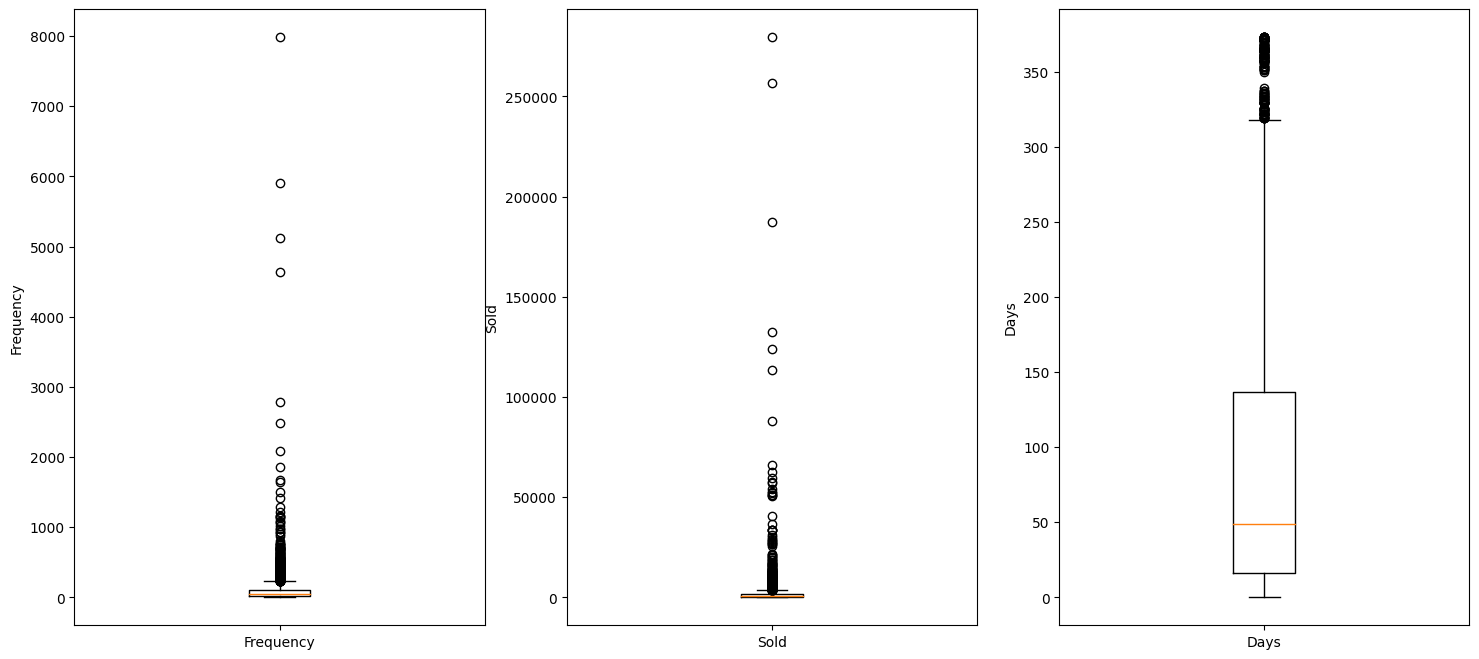

In [17]:
columns = ['Frequency', 'Sold', 'Days']
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,8)

for i,ax in enumerate(axes.flatten()):
    col=columns[i]
    ax.boxplot(retail[col], labels=[col])
    ax.set_ylabel(col)
    
plt.show()

Como muestran las cifras, el número de valores atípicos es enorme. Los valores atípicos se calculan como valores entre (Q1 - 1,5 * IQR) y (Q3 + 1,5 * IQR), donde Q1 es el cuantil del 25 %, Q3 es el cuantil del 75 % y IQR es la diferencia entre Q3 y Q1.

Entonces, nuestro número de valores atípicos es el siguiente:

In [ ]:
#
Q3 = retail['Frequency'].quantile(0.75)
Q1 = retail['Frequency'].quantile(0.25)
IQR = Q3 - Q1
freq_outliers = len(retail[(retail['Frequency'] < (Q1-1.5*IQR)) | (retail['Frequency'] > (Q3+1.5*IQR))])
print('hay {} outliers en Frequency ({:.2f}%)'.format(freq_outliers, (freq_outliers/len(retail))*100))

#
Q3 = retail['Sold'].quantile(0.75)
Q1 = retail['Sold'].quantile(0.25)
IQR = Q3 - Q1
sold_outliers = len(retail[(retail['Sold'] < (Q1-1.5*IQR)) | (retail['Sold'] > (Q3+1.5*IQR))])
print('hay {} outliers en Sold ({:.2f}%)'.format(sold_outliers, (sold_outliers/len(retail))*100))

#
Q3 = retail['Days'].quantile(0.75)
Q1 = retail['Days'].quantile(0.25)
IQR = Q3 - Q1
days_outliers = len(retail[(retail['Days'] < (Q1-1.5*IQR)) | (retail['Days'] > (Q3+1.5*IQR))])
print('hay {} outliers en Days ({:.2f}%)'.format(days_outliers, (days_outliers/len(retail))*100))

hay 380 outliers en  Frequency (8.79%)
hay 418 outliers en Sold (9.67%)
hay 171 outliers en Days (3.96%)


Como esperábamos debido a la inspección visual, los valores son enormes. Esta situación puede afectar significativamente a los resultados finales, por lo que podemos intentar corregirla.

Podemos definir el Q1 como el cuantil 5% y el Q3 como el 95%. Esto disminuirá la cantidad de valores atípicos y eliminaremos los nuevos valores atípicos.

In [ ]:
size_before = len(retail)

#Frequency
Q3 = retail['Frequency'].quantile(0.95)
Q1 = retail['Frequency'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Frequency'] >= (Q1-1.5*IQR)) & (retail['Frequency'] <= (Q3+1.5*IQR))]

#Sold
Q3 = retail['Sold'].quantile(0.95)
Q1 = retail['Sold'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Sold'] >= (Q1-1.5*IQR)) & (retail['Sold'] <= (Q3+1.5*IQR))]

#Days
Q3 = retail['Days'].quantile(0.95)
Q1 = retail['Days'].quantile(0.05)
IQR = Q3 - Q1
retail = retail[(retail['Days'] >= (Q1-1.5*IQR)) & (retail['Days'] <= (Q3+1.5*IQR))]

print("La longitud del nuevo marco de datos es {}, {} filas se eliminaron".format(len(retail), size_before-len(retail)))

La longitud del nuevo marco de datos es4240, 82 se eliminaron filas


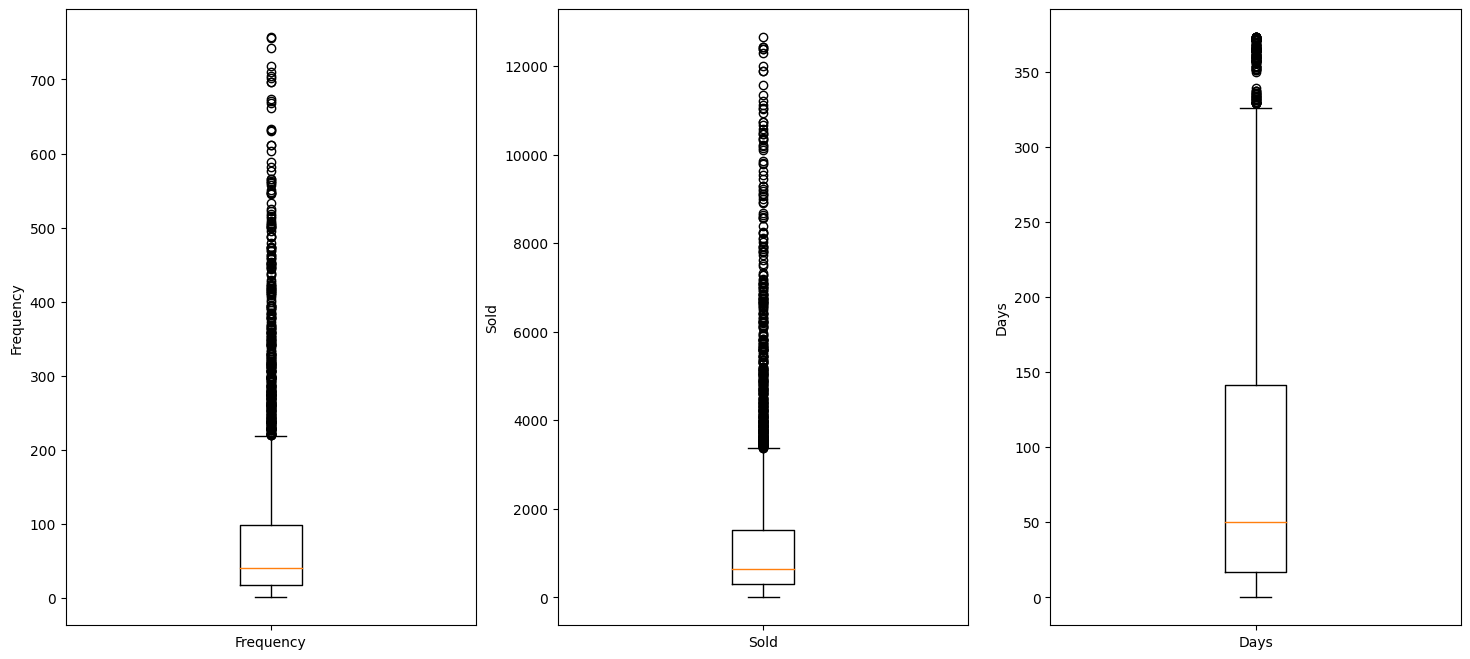

In [20]:
columns = ['Frequency', 'Sold', 'Days']
fig, axes = plt.subplots(1,3)
fig.set_size_inches(18,8)

for i,ax in enumerate(axes.flatten()):
    col=columns[i]
    ax.boxplot(retail[col], labels=[col])
    ax.set_ylabel(col)
    
plt.show()

# 2. K-Means model

## 2.1. Número de conglomerados

Nadie nos ha dicho en cuántos grupos debemos agrupar a los clientes, por lo que dejaremos que el propio modelo defina el valor óptimo.

Comenzaremos creando la curva Codo para seleccionar la mejor cantidad de grupos.

In [21]:
X = retail.values[:,1:]

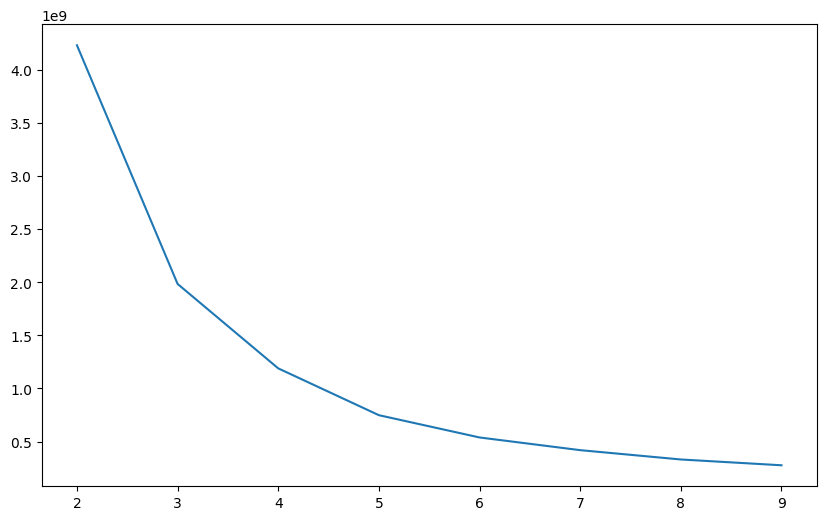

In [22]:
dist = []
clusters = [2, 3, 4, 5, 6, 7, 8, 9]
for cluster in clusters:
    k_means = KMeans(n_clusters=cluster, max_iter=50).fit(X)
    dist.append(k_means.inertia_)

plt.figure(figsize=(10,6))
plt.plot(clusters,dist)
plt.show()

La curva del codo nos dice, mediante un cambio significativo en la pendiente, cuál debe ser el número de conglomerados. A la vista de los resultados, 3 y 4 parecen conseguirlo.

Tracemos el análisis de la silueta para aclarar esta situación:

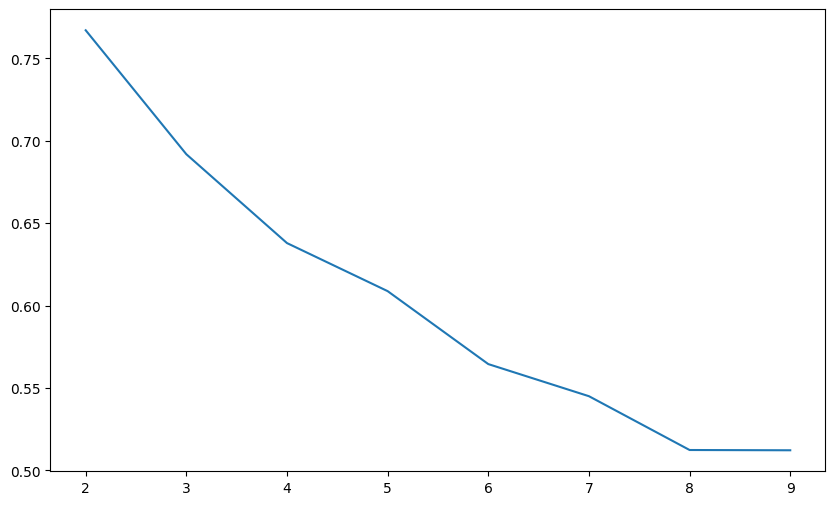

In [23]:
scores = []

for cluster in clusters:
    k_means = KMeans(n_clusters = cluster).fit(X)
    labels = k_means.labels_
    scores.append(silhouette_score(X, labels, metric = 'euclidean'))
    
plt.figure(figsize=(10,6))
plt.plot(clusters,scores)
plt.show()

Tres clusters presentan mejor valor que 4, por lo que podemos concluir que el mejor valor es 3.

## 2.2. Model

Calcularemos a qué cluster pertenece cada cliente:

In [ ]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=25)
k_means.fit(X)
labels = k_means.labels_

retail['Cluster'] = k_means.labels_
retail.head()
retail.to_csv("./Data/Cluster_Result.csv")

## 2.3. Visual analysis

No sabemos cómo se ha agrupado el modelo, pero podemos inspeccionar estos valores usando diagramas de caja:

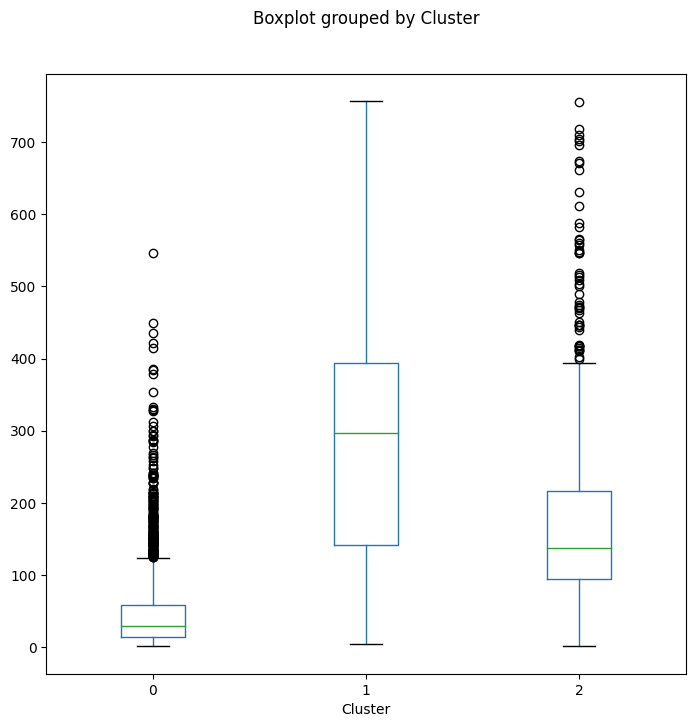

In [25]:
warnings.filterwarnings("ignore")
retail.boxplot(column='Frequency',by='Cluster',grid=False,figsize=(8,8))
plt.title(None)
plt.show()

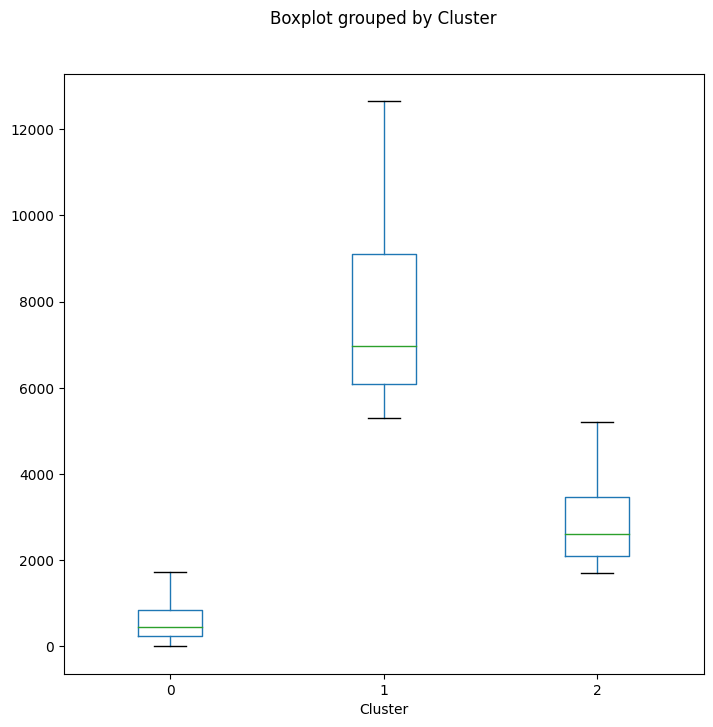

In [26]:
retail.boxplot(column='Sold',by='Cluster',grid=False,figsize=(8,8))
plt.title(None)
plt.show()

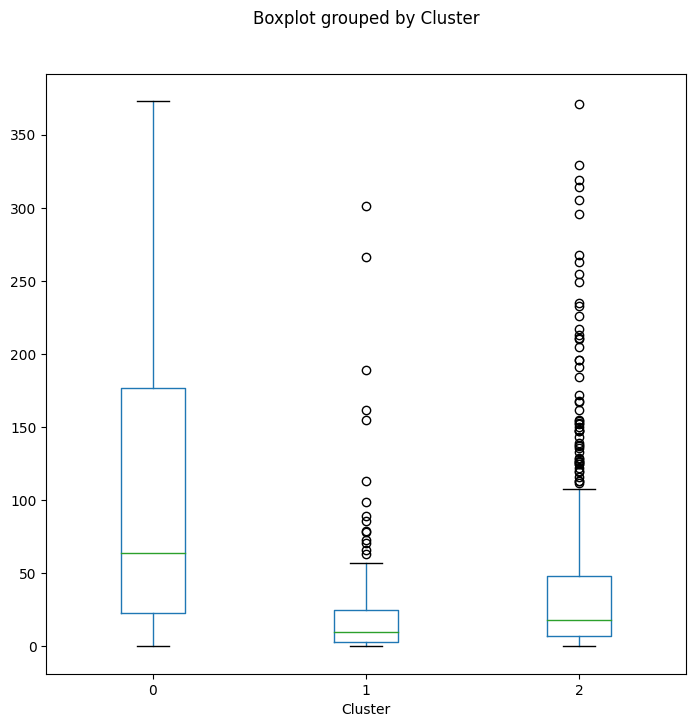

In [27]:
retail.boxplot(column='Days',by='Cluster', grid=False,figsize=(8,8))
plt.title(None)
plt.show()

Another way to visualize them is to present graphs that face the variables, using different colors for each cluster:

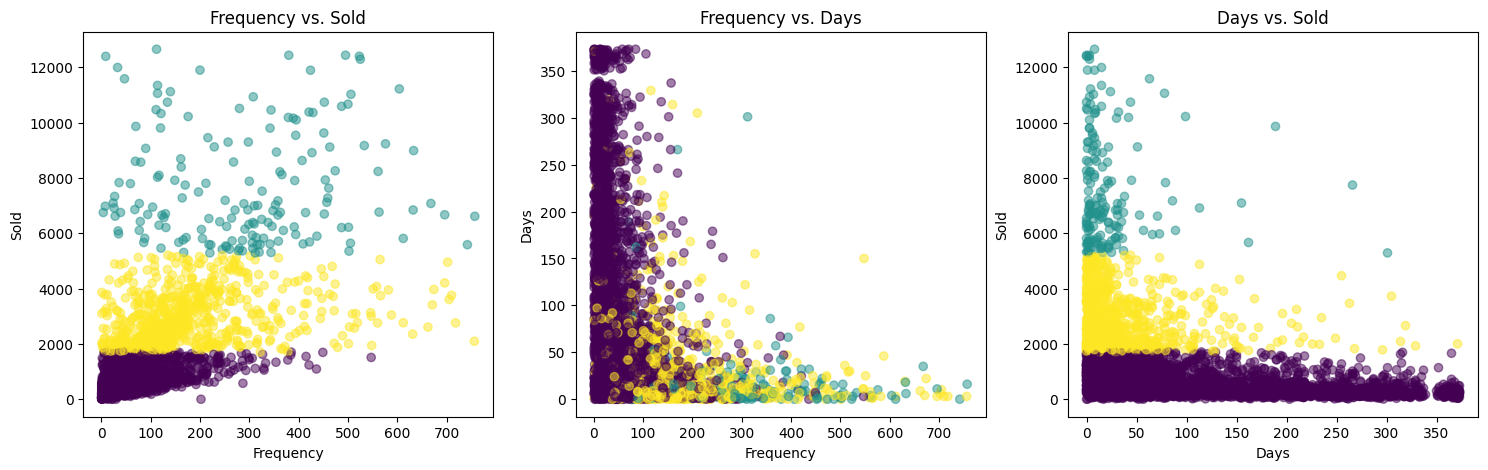

In [28]:
columns = ['Frequency', 'Sold', 'Days', 'Freq']
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 5)

for i, ax in enumerate(axes.flatten()):
    if i < 2:
        j = 0
        k = i + 1
    else:
        j = i
        k = i - 1

    ax.scatter(X[:, j], X[:, k], c=labels.astype(float), alpha=0.5)
    ax.set_xlabel(columns[j])
    ax.set_ylabel(columns[k])
    ax.set_title(columns[j] + ' vs. ' + columns[k])

plt.show()

## 2.4. Análisis numérico

Agrupemos los valores medios para determinar qué tipos de clientes incluyen

In [29]:
grouped = retail.groupby('Cluster').mean()
grouped = grouped.astype({'Frequency':int, 'Sold':int, 'Days':int})
grouped

,Frequency,Sold,Days
Cluster,,,
0,45,577,107
1,288,7667,23
2,172,2856,36


Según la tabla anterior, podemos concluir lo siguiente:
<ul>
     <li><b>Clúster 0</b>: clientes con compras separadas en el tiempo, pocos productos y alrededor de 500€.</li>
     <li><b>Clúster 1</b>: los clientes compran un número elevado de productos mensualmente y una cantidad muy elevada (más de 7.000€).</li>
     <li><b>Clúster 2</b>: clientes que también compran casi mensualmente, pero menos productos y poco dinero (alrededor de 3.000€).</li>
</ul>